In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


from Lineaire.Linear import *
from Loss.BCELoss import BCELoss
from Loss.CELogSoftMax import CELogSoftMax
from Activation.Tanh import Tanh
from Activation.Sigmoide import Sigmoide
from Activation.ReLu import ReLU
from Activation.SoftMax import  SoftMax
from Encapsulation.AutoEncodeur import AutoEncodeur
from Encapsulation.Sequentiel import Sequentiel
from Encapsulation.Optim import SGD
from Encapsulation.fonctions import *

from utils import tools


In [2]:
L = Linear(2, 2)
isinstance(L, Linear)

True

In [2]:
np.random.seed(5)

- Reconstruction d'images avec auto-encodeurs
- Extraction des représentations pour clusteriser et classifier les images.

# Dataset: SKLearn Digits

## Chargement et standardisation des données

In [2]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Avec minmax scaler ca marche pas, toujours la meme image reconstruite avec différents exemples

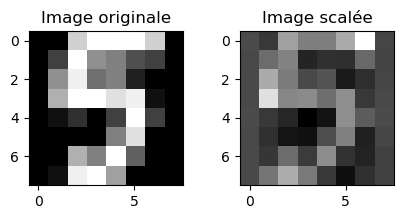

In [5]:
plt.figure(figsize=(5,2))
plt.subplot(1,2,1)
plt.title("Image originale")
plt.imshow(X_train[5].reshape((8,8)), cmap='grey')
plt.subplot(1,2,2)
plt.imshow(X_train_scaled[5].reshape((8,8)), cmap='grey')
plt.title("Image scalée")
plt.show()

## Reconstruction

In [3]:
loss_bce = BCELoss()
lineaire1 = Linear(X_train.shape[1], 32, init_type=1)
lineaire2 = Linear(32, 8, init_type=1)
lineaire3 = Linear(8, 32, init_type=1)
lineaire4 = Linear(32, 64, init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)

net, couts, opt = SGD(net, X_train_scaled, X_train_scaled,nb_batch=10, loss=loss_bce, nb_epochs=iter, eps=1e-1, shuffle=True)
#X.shape: (1437, 64), Y.shape: (1437, 64)

100%|██████████| 100/100 [00:02<00:00, 35.76it/s]


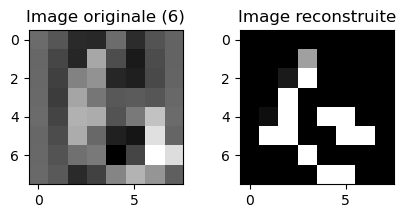

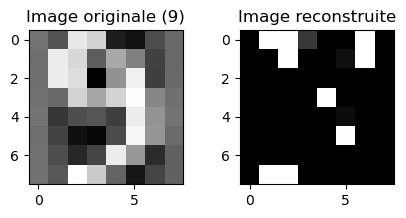

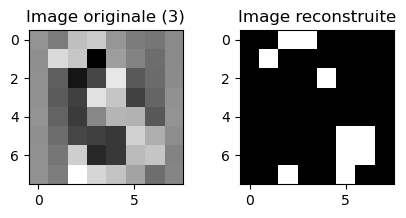

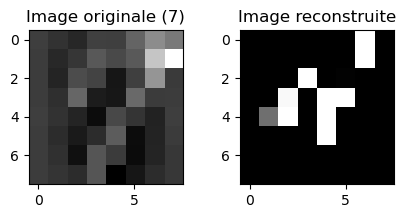

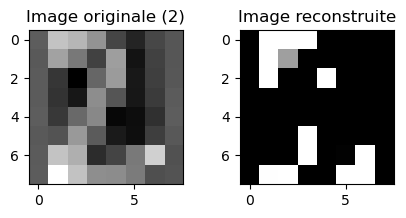

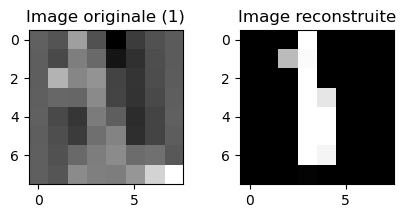

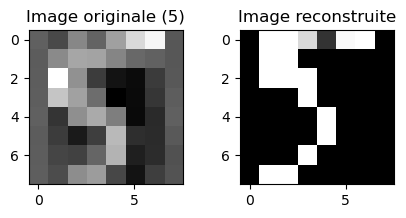

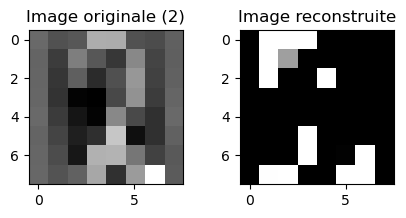

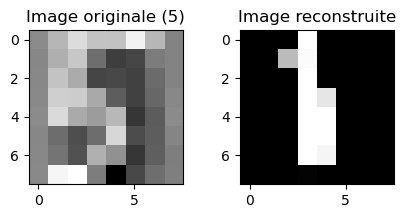

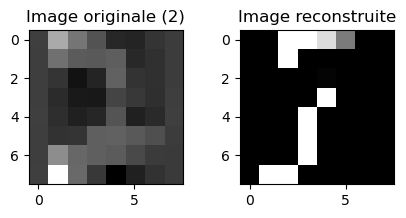

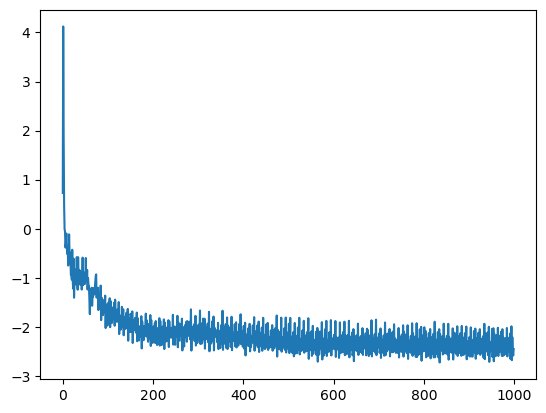

In [41]:
predict(opt, 10, X_test_scaled, y_test)

plt.plot(range(len(couts)), couts)
plt.show()

# Dataset: USPS

In [4]:
path_train = "dataset/USPS_train.txt"
path_test = "dataset/USPS_test.txt"

trainx, train_y = tools.load_usps(path_train)
testx, test_y = tools.load_usps(path_test)

scaler = StandardScaler()
scaler.fit(trainx)
trainx = scaler.transform(trainx)
testx = scaler.transform(testx)
del scaler

print(f'{trainx.shape = }') # Images de taille 16*16 pixels

trainx.shape = (7291, 256)


## Reconstruction

### Config 1

In [5]:
loss_bce = BCELoss()
lineaire1 = Linear(trainx.shape[1], 64, init_type=1)
lineaire2 = Linear(64, 10, init_type=1)
lineaire3 = Linear(10, 64, init_type=1)
lineaire4 = Linear(64, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)
net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_bce, nb_epochs=iter, eps=1e-2, shuffle=True)


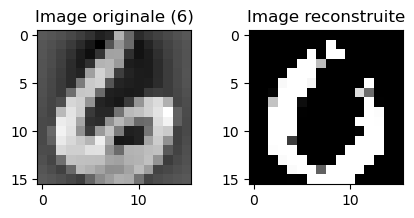

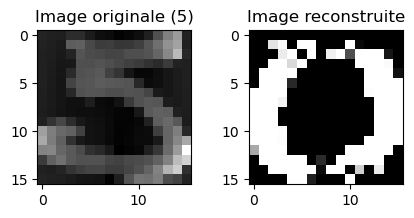

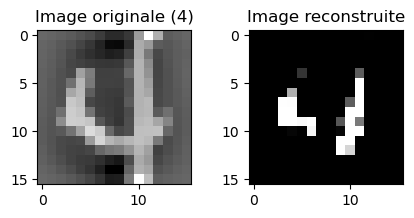

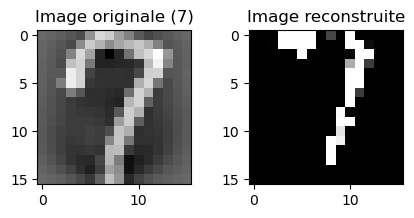

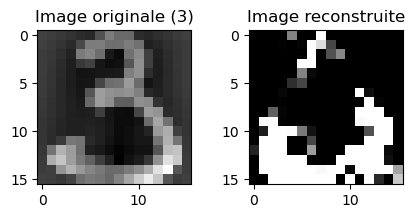

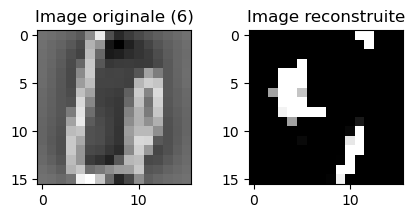

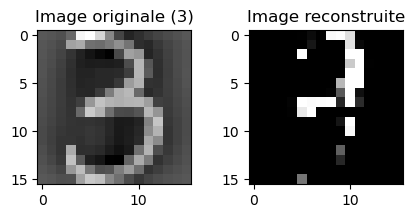

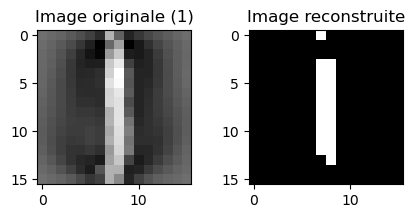

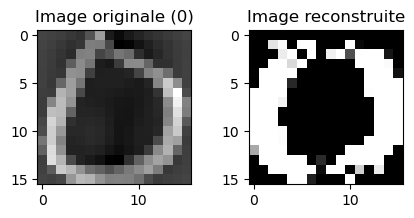

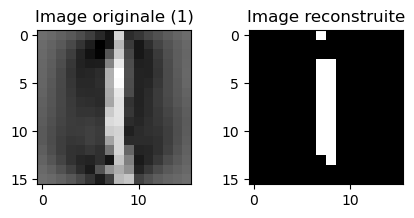

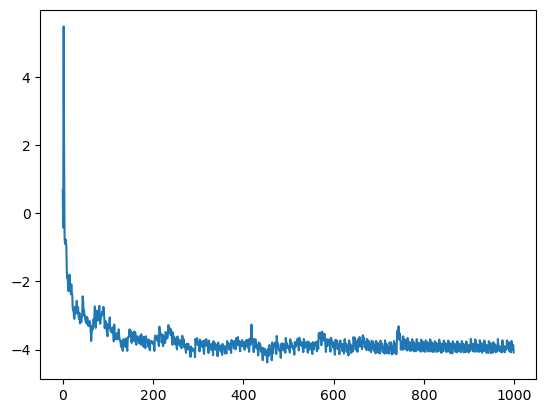

In [6]:
evaluate(opt, trainx, train_y)

### Config 2

In [5]:
loss_bce = BCELoss()
lineaire1 = Linear(trainx.shape[1], 128, init_type=1)
lineaire2 = Linear(128, 4, init_type=1)
lineaire3 = Linear(4, 128, init_type=1)
lineaire4 = Linear(128, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)


net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_bce, nb_epochs=iter, eps=1e-2, shuffle=True)


100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


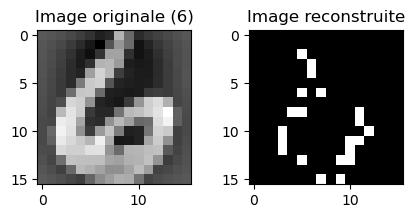

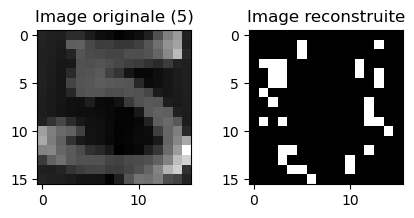

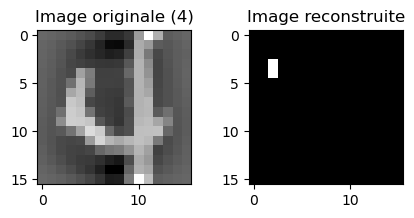

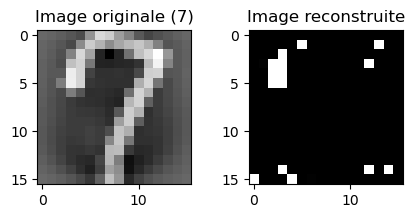

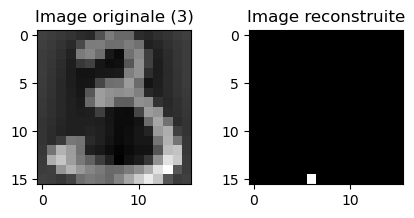

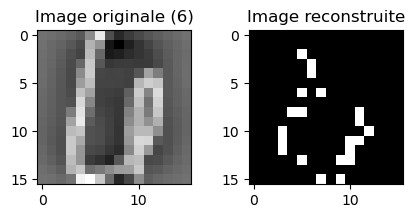

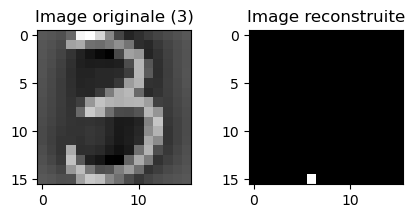

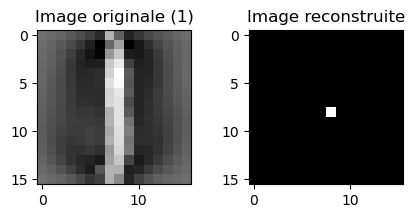

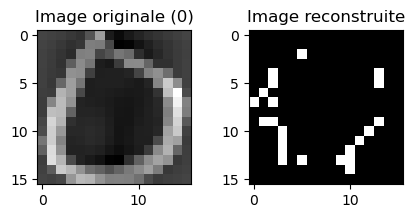

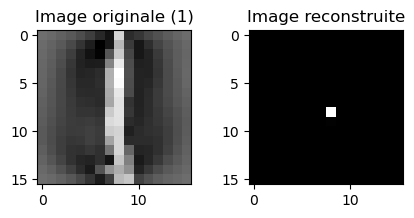

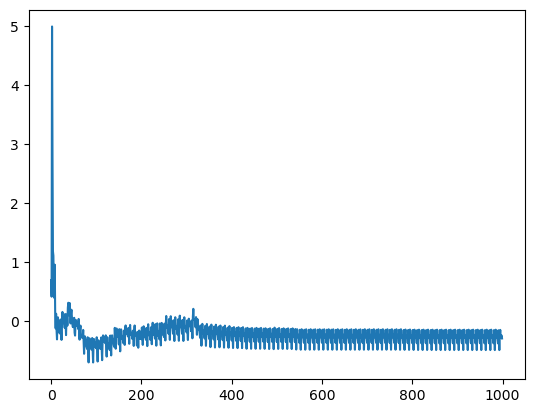

In [7]:
evaluate(opt, trainx, train_y) 

### Config 3

In [8]:
loss_mse = BCELoss()
lineaire1 = Linear(trainx.shape[1], 100, init_type=1)
lineaire2 = Linear(100, 10, init_type=1)
lineaire3 = Linear(10, 100, init_type=1)
lineaire4 = Linear(100, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_mse, nb_epochs=iter, eps=1e-2, shuffle=True)


100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


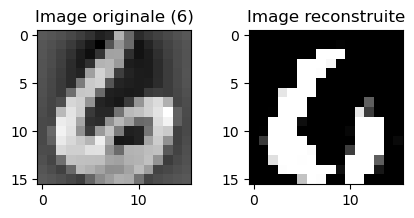

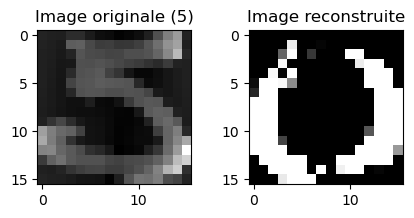

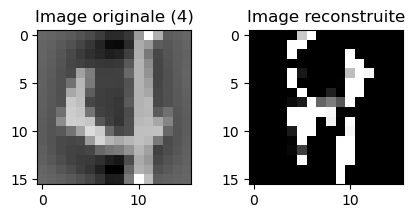

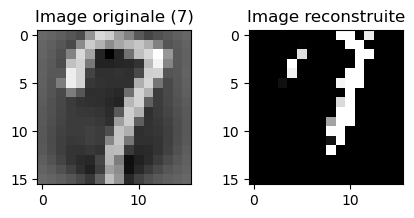

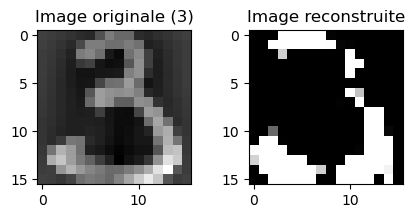

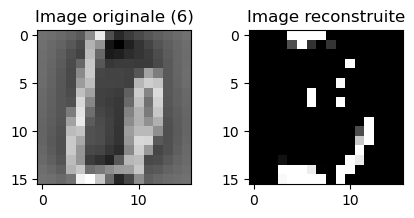

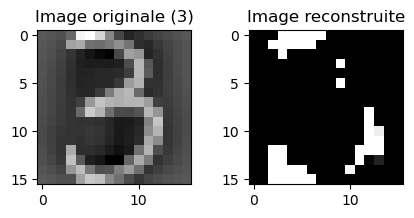

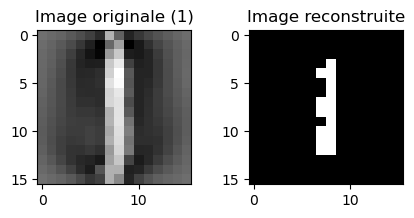

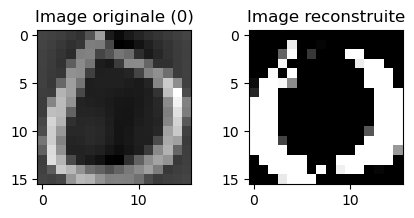

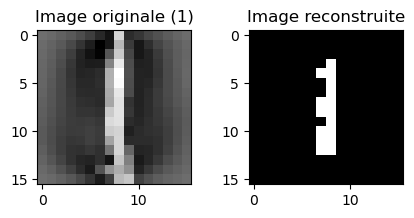

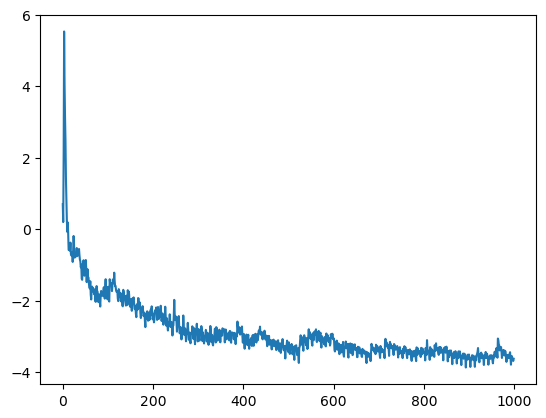

In [10]:
evaluate(opt, trainx, train_y) 

## Clustering

### Images originales

Clusteriser les images originales

In [6]:
nb_clusters = 10
kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(trainx)

# Pour obtenir les étiquettes de cluster pour chaque image
labels = kmeans.predict(trainx)

image_cluster = []

# Associer chaque image au cluster auquel elle appartient
for i in range(len(labels)):
    image_cluster.append((i,labels[i]))
    
df_ori = pd.DataFrame(image_cluster, columns=['Image', 'Cluster'])
print(len(df_ori), 'lignes')
df_ori.head()

7291 lignes


,Image,Cluster
0,0,3
1,1,1
2,2,9
3,3,7
4,4,1


Remarque: Les valeurs dans la colonne 'cluster' sont juste des identifiants du cluster

cluster 0


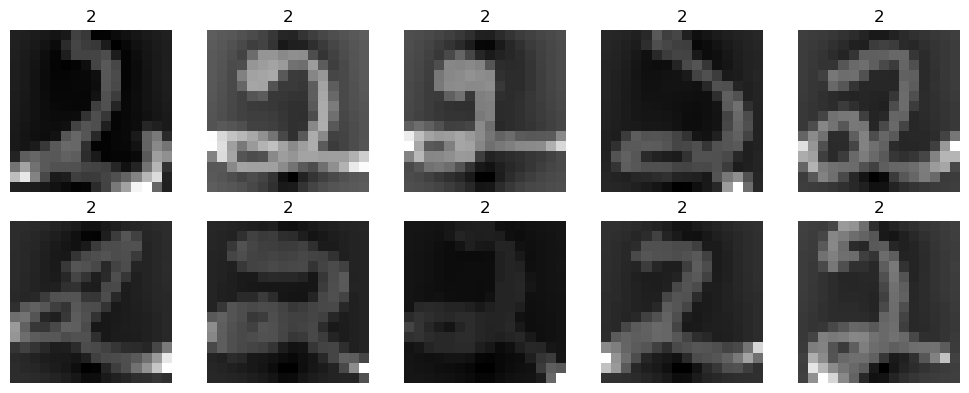

cluster 1


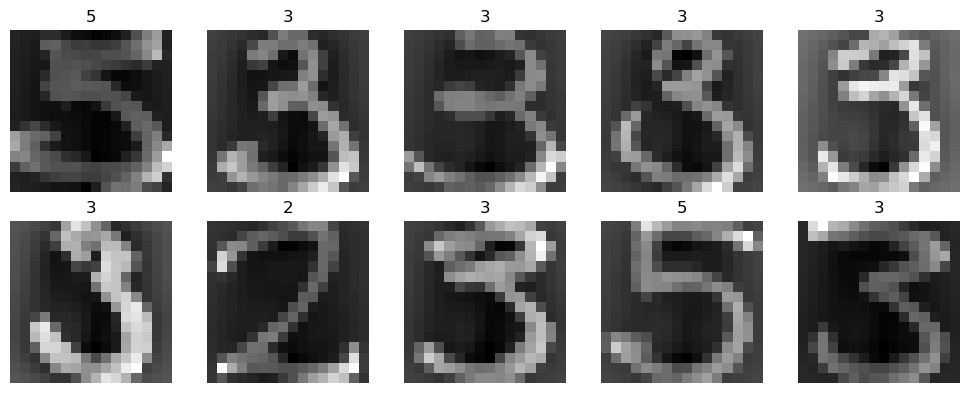

cluster 2


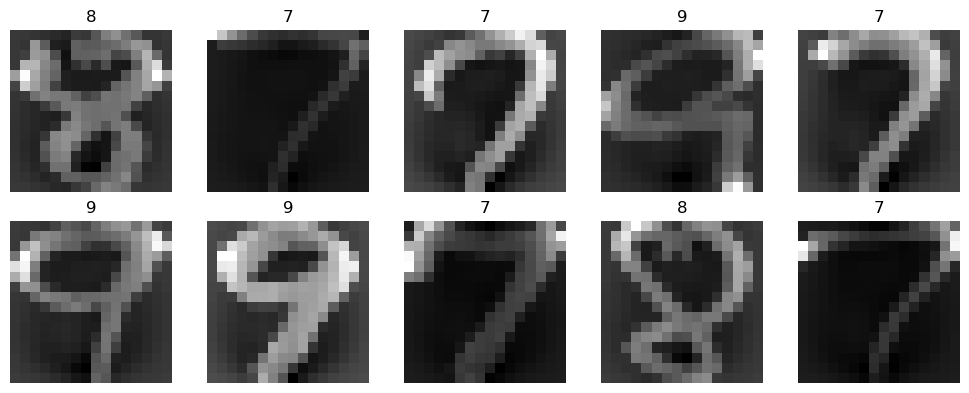

cluster 3


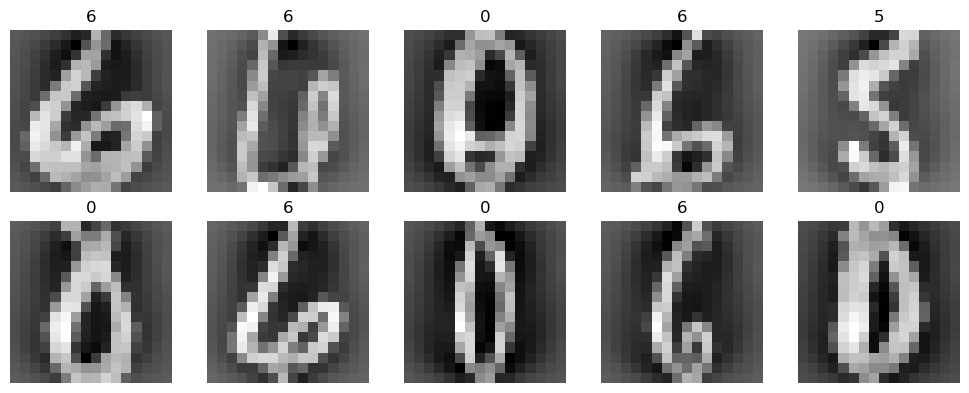

cluster 4


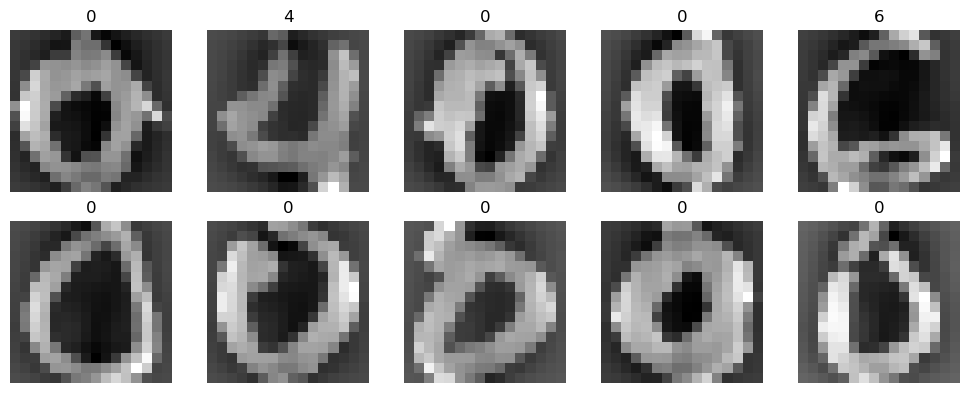

cluster 5


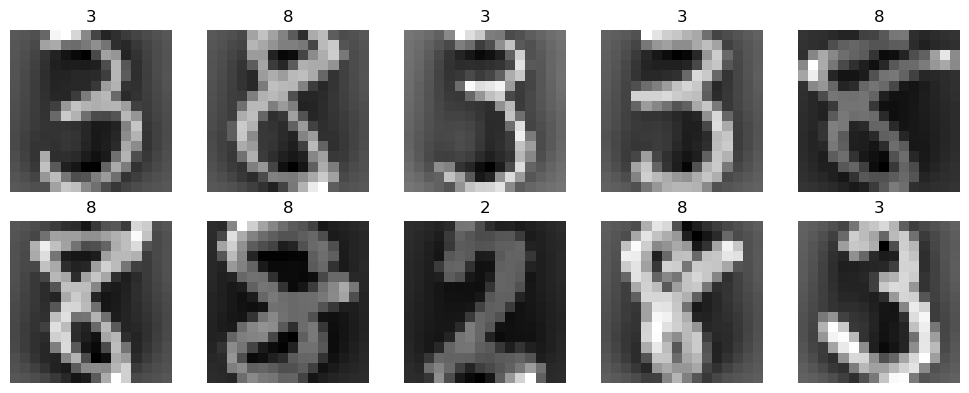

cluster 6


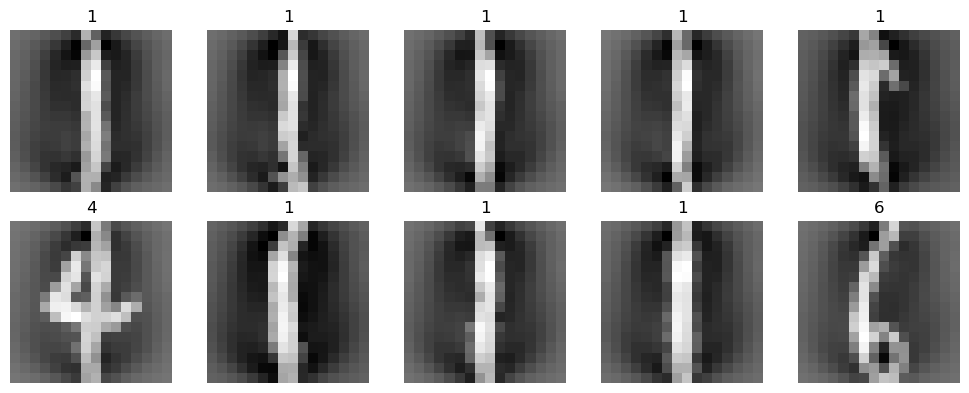

cluster 7


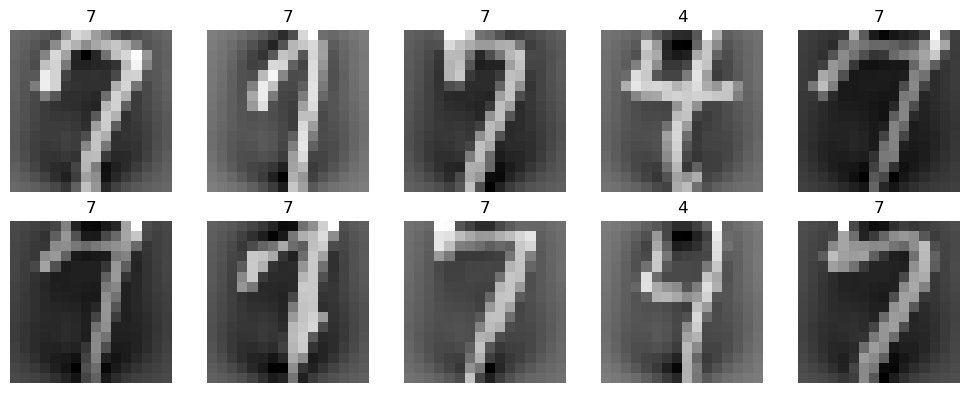

cluster 8


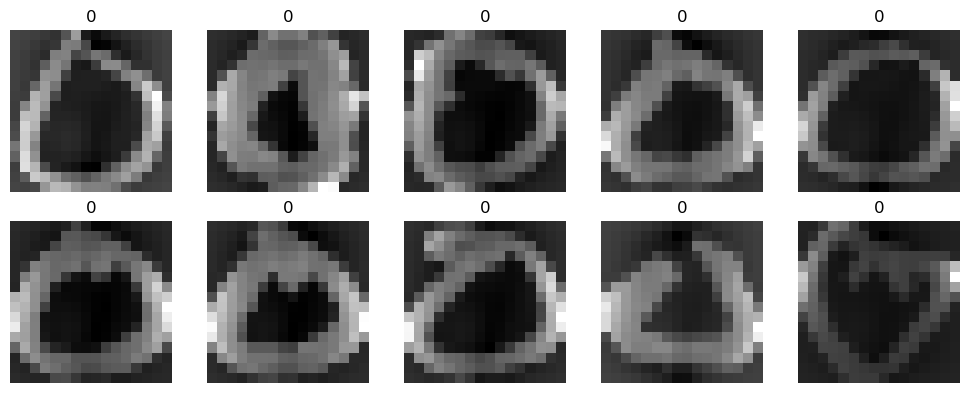

cluster 9


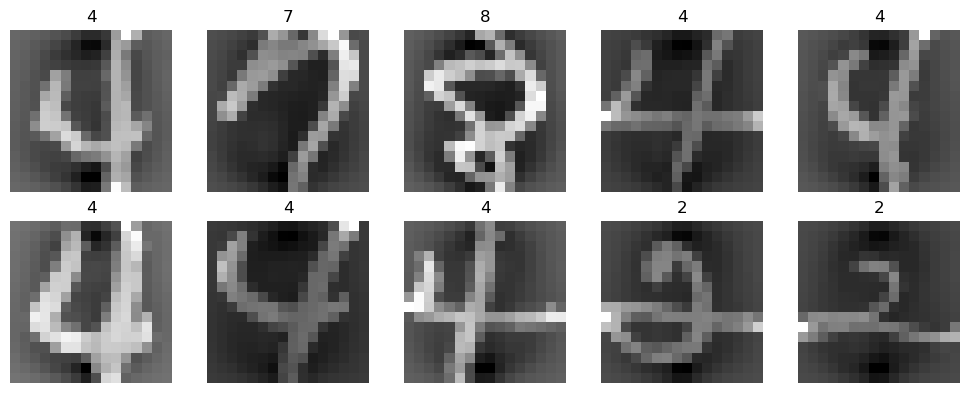

In [7]:
groupes = df_ori.groupby('Cluster')
groupes_df_ori = []

# Récupérer les images par cluster
for cluster, groupe_df in groupes:
    #print("Images du cluster", cluster)
    #print(groupe_df)
    groupes_df_ori.append(groupe_df)
    #print("\n")

# Visualisation 
for i in range(nb_clusters):
    print('cluster', i)
    afficher_images_cluster(groupes_df_ori[i], trainx, train_y)

### Representations

Entraîner un autoencodeur sur les images et clusteriser les representations latentes

In [9]:
loss_bce = BCELoss()
lineaire1 = Linear(trainx.shape[1], 64, init_type=1)
lineaire2 = Linear(64, 10, init_type=1)
lineaire3 = Linear(10, 64, init_type=1)
lineaire4 = Linear(64, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_bce, nb_epochs=iter, eps=1e-2, shuffle=True)


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


In [10]:
representations_latentes = np.array([net.get_representation_latente(trainx[i].reshape((1,256))) for i in range(len(trainx))])
representations_latentes = np.squeeze(representations_latentes)
np.savetxt('representations_latentes2.txt', representations_latentes)
representations_latentes

array([[ 1., -1., -1., ..., -1.,  1.,  1.],
       [ 1.,  1., -1., ..., -1., -1., -1.],
       [ 1., -1.,  1., ...,  1., -1.,  1.],
       ...,
       [-1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1.,  1., -1., ..., -1., -1.,  1.],
       [-1., -1.,  1., ...,  1.,  1.,  1.]])

In [20]:
representations_latentes = np.loadtxt('representations_latentes/representations_latentes2.txt')

In [11]:
kmeans_rep = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(representations_latentes)
# Pour obtenir les étiquettes de cluster pour chaque image
labels_rep = kmeans_rep.predict(representations_latentes)
image_cluster_rep = []

# Associer chaque image à son cluster
for i in range(len(labels_rep)):
    image_cluster_rep.append((i,labels_rep[i]))

df_rep = pd.DataFrame(image_cluster_rep, columns=['RepresentationLatente', 'Cluster'])
df_rep

,RepresentationLatente,Cluster
0,0,3
1,1,8
2,2,1
3,3,2
4,4,3
...,...,...
7286,7286,6
7287,7287,1
7288,7288,6
7289,7289,8


cluster 0


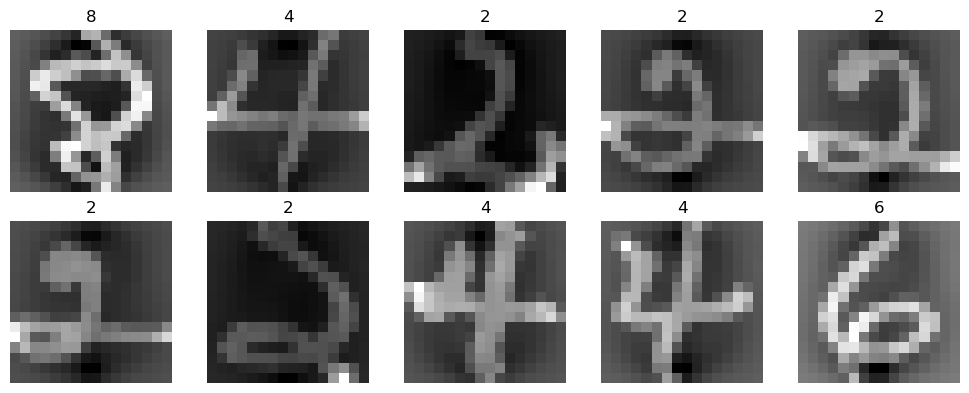

cluster 1


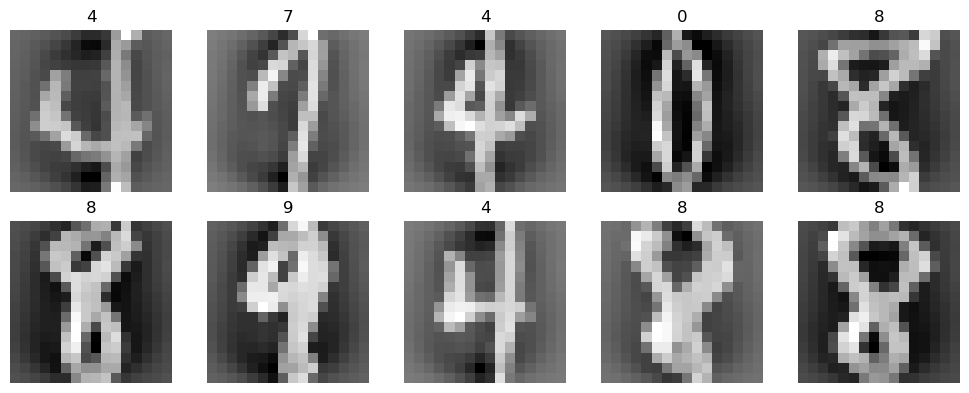

cluster 2


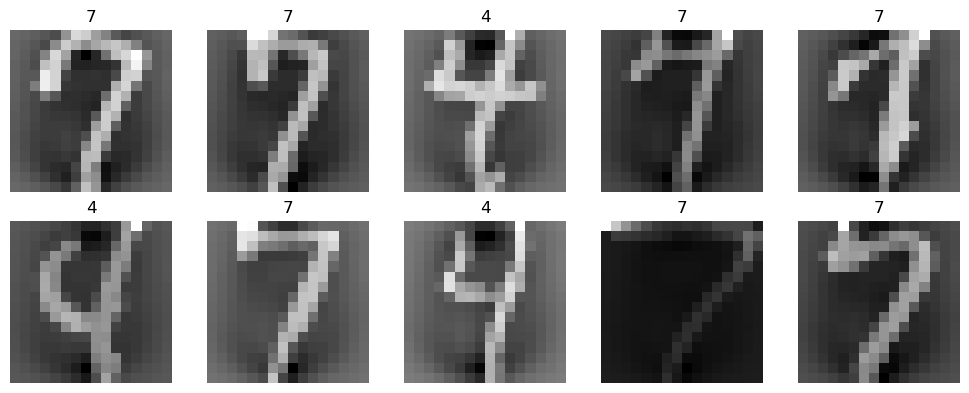

cluster 3


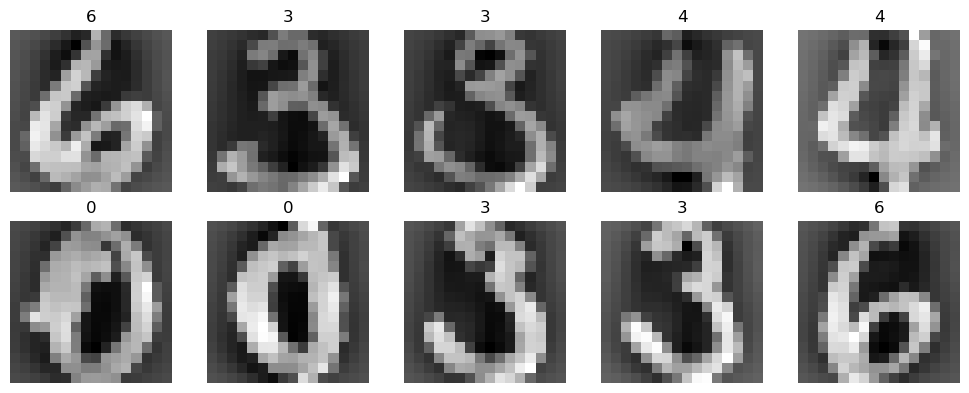

cluster 4


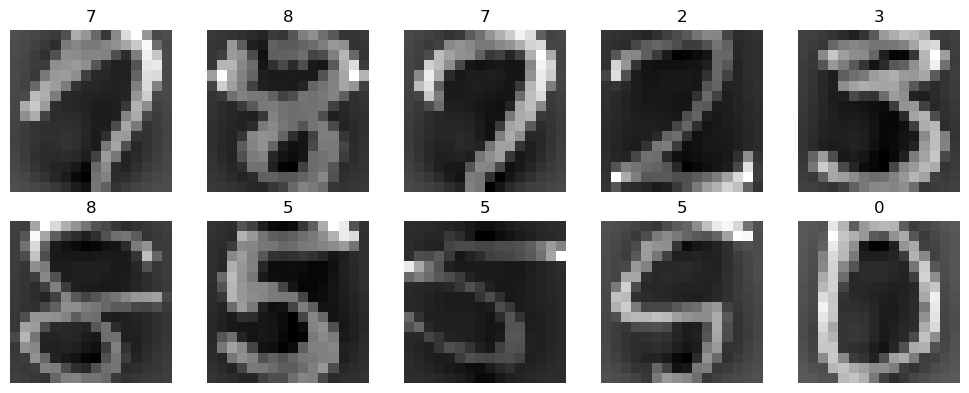

cluster 5


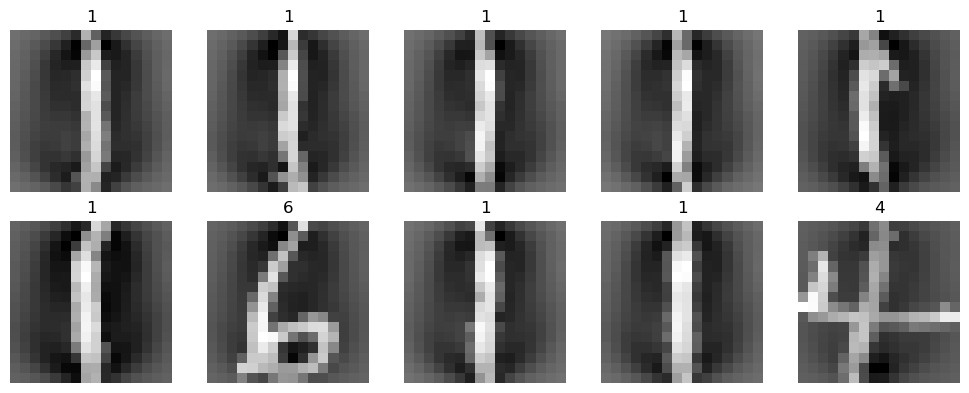

cluster 6


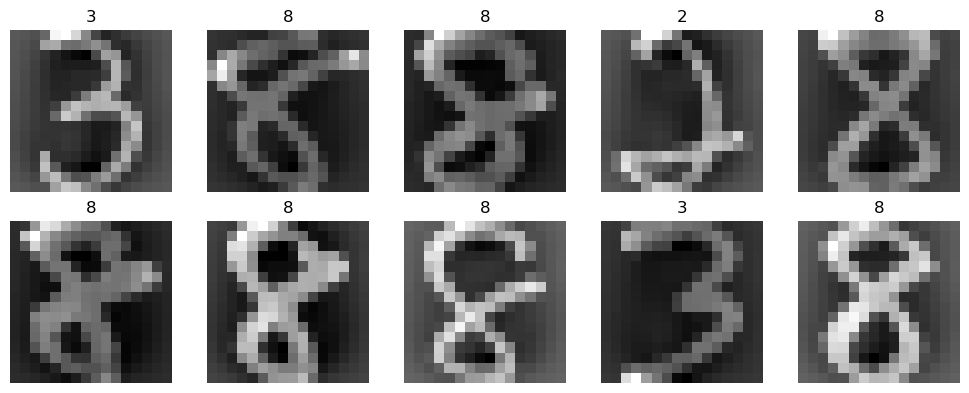

cluster 7


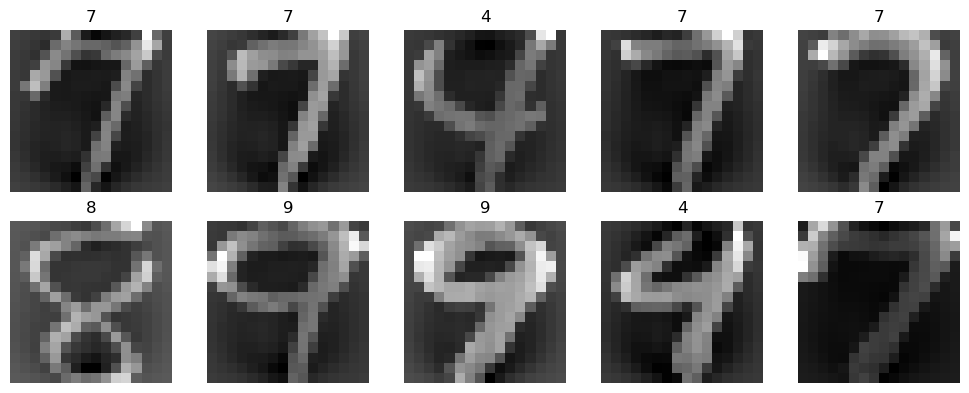

cluster 8


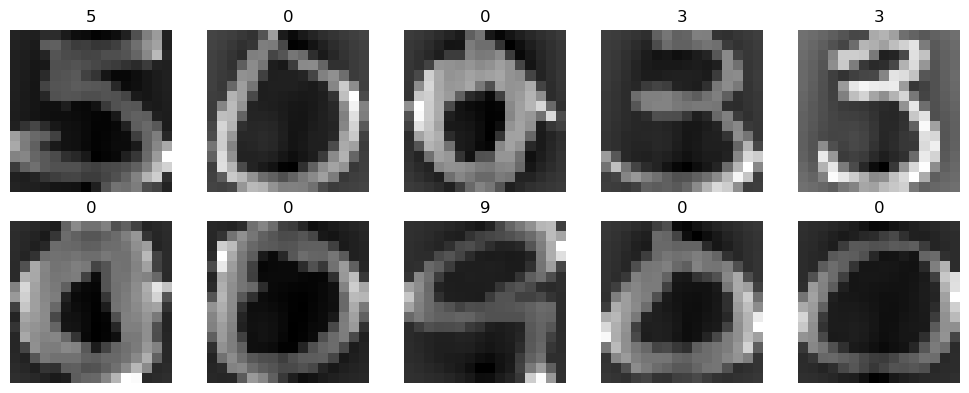

cluster 9


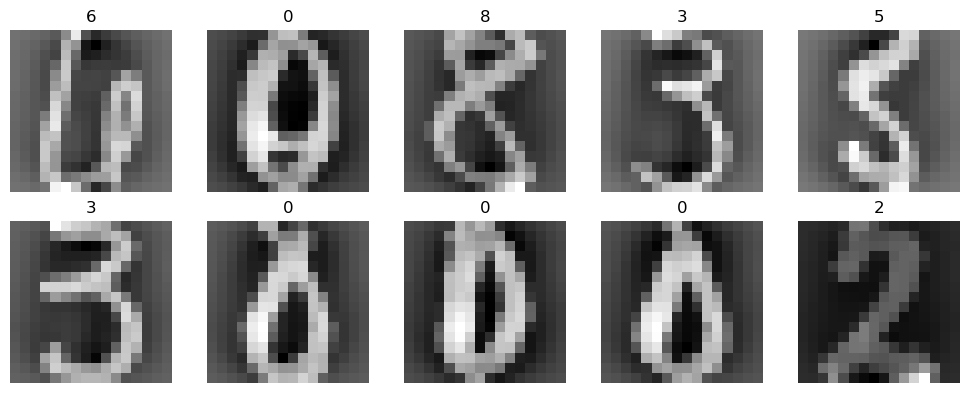

In [13]:
groupes = df_rep.groupby('Cluster')
groupes_df_rep = []
# Parcourir chaque groupe
for cluster, groupe_df in groupes:
    # print("Cluster", cluster)
    # print(groupe_df)
    groupes_df_rep.append(groupe_df)
    # print("\n")
    
for i in range(10):
    print('cluster', i)
    afficher_images_cluster_rep(groupes_df_rep[i], trainx, train_y)

### Comparaison des clusterings

In [29]:
df_eval = pd.DataFrame([
    ('score silhouette', silhouette_score(trainx, labels), silhouette_score(representations_latentes, labels_rep)),
     ('Inertie', kmeans.inertia_, kmeans_rep.inertia_)
], columns=['Metrique', 'Clustering espace original', 'Clustering espace latent'])
df_eval#V2

,Metrique,Clustering espace original,Clustering espace latent
0,score silhouette,1.069662e-01,0.331994
1,Inertie,1.227543e+06,21396.204669


In [34]:
for df in groupes_df_rep:
    df['Chiffre'] = [train_y[rep] for rep in df['RepresentationLatente']]
    
cluster_valMaj_purete = []
for df in groupes_df_rep:
    value_count = df['Chiffre'].value_counts()
    cluster_valMaj_purete.append((df.iloc[0]["Cluster"], value_count.idxmax(), value_count.max()/len(df)))

df_cluster_valMaj_purete = pd.DataFrame(cluster_valMaj_purete, columns=['Cluster', 'ValeurMajoritaire', 'purete'])
print('mean: ', np.mean(df_cluster_valMaj_purete['purete'].to_list()))
print('std: ',np.std(df_cluster_valMaj_purete['purete'].to_list()))
df_cluster_valMaj_purete


mean:  0.45609751632155804
std:  0.1447375538496278


,Cluster,ValeurMajoritaire,purete
0,0,2,0.620690
1,1,8,0.424242
2,2,9,0.399423
3,3,0,0.474866
4,4,5,0.206897
5,5,1,0.686671
6,6,3,0.458774
7,7,7,0.561404
8,8,0,0.495336
9,9,0,0.232673


'pureté = le nombre d'occurrences du chiffre le plus présent dans le cluster / le nombre d'éléments du cluster

In [37]:
for df in groupes_df_ori:
    df['Chiffre'] = [train_y[rep] for rep in df['Image']]
    
cluster_valMaj_purete_ori = []
for df in groupes_df_ori:
    value_count = df['Chiffre'].value_counts()
    cluster_valMaj_purete_ori.append((df.iloc[0]["Cluster"], value_count.idxmax(), value_count.max()/len(df)))

df_cluster_valMaj_purete_ori = pd.DataFrame(cluster_valMaj_purete_ori, columns=['Cluster', 'ValeurMajoritaire', 'purete'])

print('mean: ', np.mean(df_cluster_valMaj_purete_ori['purete'].to_list()))
print('std: ',np.std(df_cluster_valMaj_purete_ori['purete'].to_list()))

df_cluster_valMaj_purete_ori

mean:  0.6694490158215818
std:  0.20374063117225286


,Cluster,ValeurMajoritaire,purete
0,0,2,0.964059
1,1,3,0.477407
2,2,7,0.537313
3,3,6,0.592244
4,4,0,0.827737
5,5,8,0.398668
6,6,1,0.909338
7,7,9,0.450000
8,8,0,0.917453
9,9,4,0.620270


### Autre configuration

In [50]:
#Ici, l'ensemble de train a été restreint aux 1000 premieres images
loss_bce = BCELoss()
lineaire1 = Linear(trainx.shape[1], 128, init_type=1)
lineaire2 = Linear(128, 64, init_type=1)
lineaire3 = Linear(64, 128, init_type=1)
lineaire4 = Linear(128, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_bce, nb_epochs=iter, eps=1e-2, shuffle=True)


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


In [51]:
representations_latentes = np.array([net.get_representation_latente(trainx[i].reshape((1,256))) for i in range(len(trainx))])
representations_latentes = np.squeeze(representations_latentes)
np.savetxt('representations_latentes.txt', representations_latentes)
representations_latentes

array([[-1.,  1., -1., ...,  1.,  1., -1.],
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1., -1.,  1.],
       ...,
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [-1., -1.,  1., ..., -1., -1., -1.]])

In [39]:
representations_latentes = np.loadtxt('representations_latentes/representations_latentes.txt')

In [40]:
kmeans_rep = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(representations_latentes)
# Pour obtenir les étiquettes de cluster pour chaque image
labels_rep = kmeans_rep.predict(representations_latentes)
image_cluster_rep = []

# Associer chaque image à son cluster
for i in range(len(labels_rep)):
    image_cluster_rep.append((i,labels_rep[i]))

df_rep = pd.DataFrame(image_cluster_rep, columns=['RepresentationLatente', 'Cluster'])
df_rep

c:\Anaconda3\envs\workspace11\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,RepresentationLatente,Cluster
0,0,3
1,1,1
2,2,6
3,3,7
4,4,1
...,...,...
995,995,8
996,996,8
997,997,5
998,998,3


cluster 0


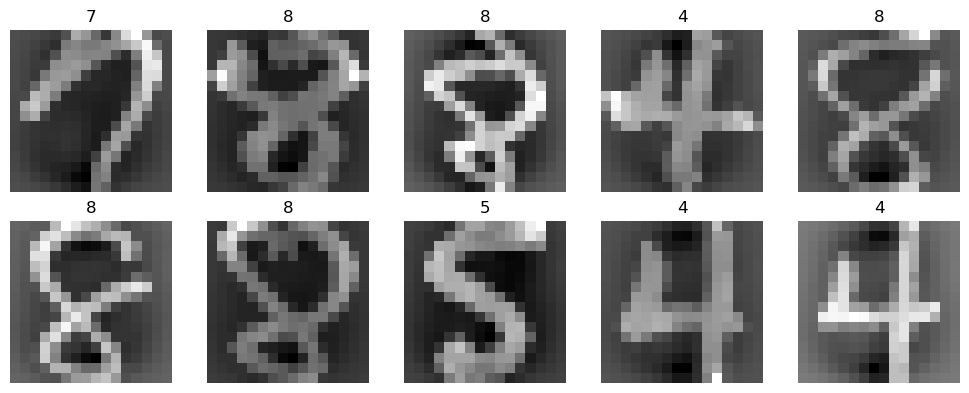

cluster 1


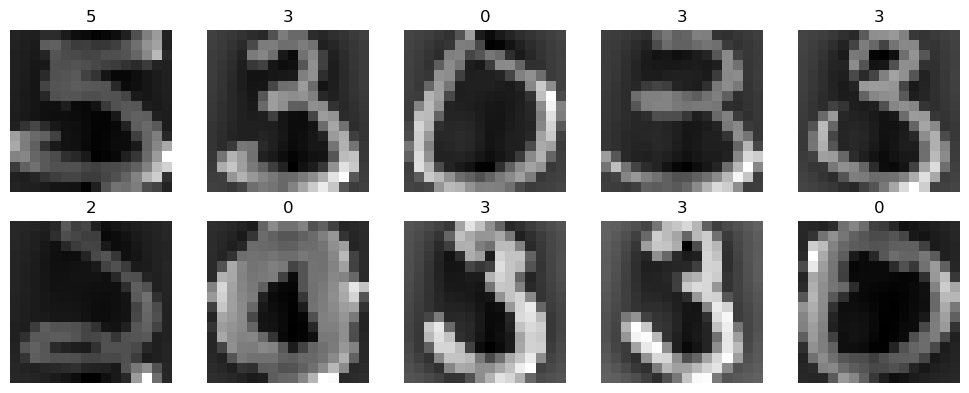

cluster 2


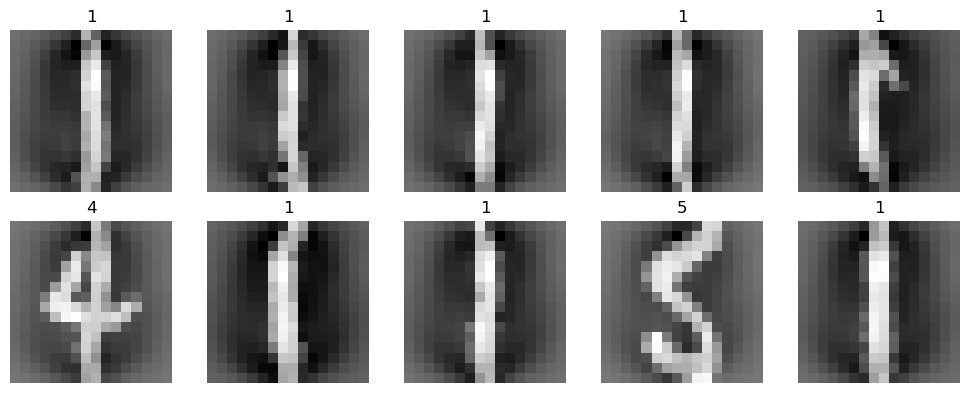

cluster 3


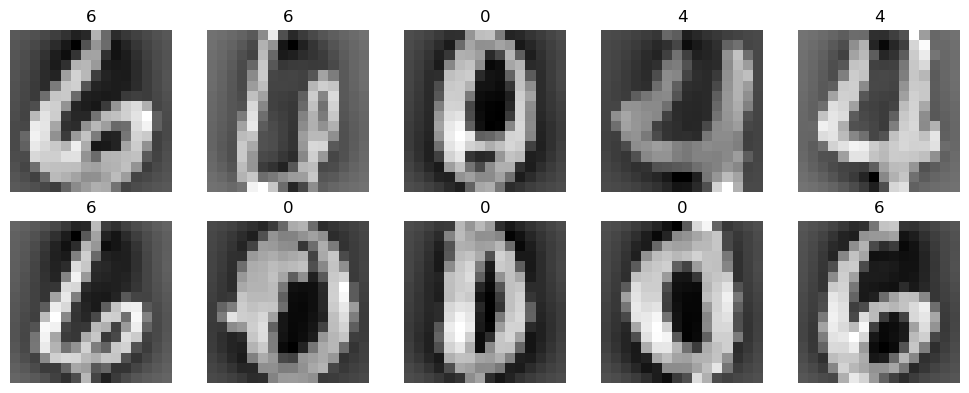

cluster 4


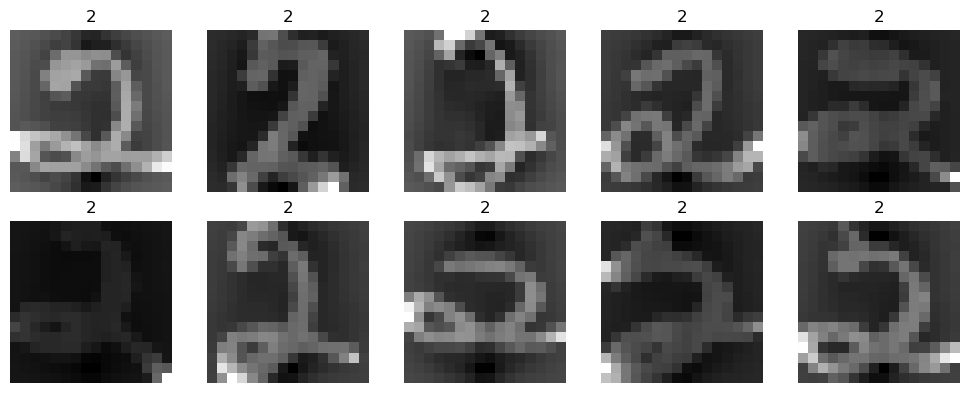

cluster 5


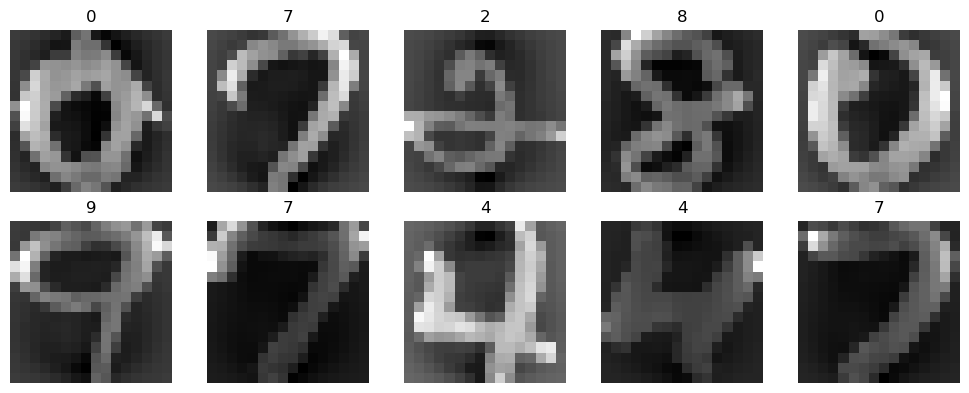

cluster 6


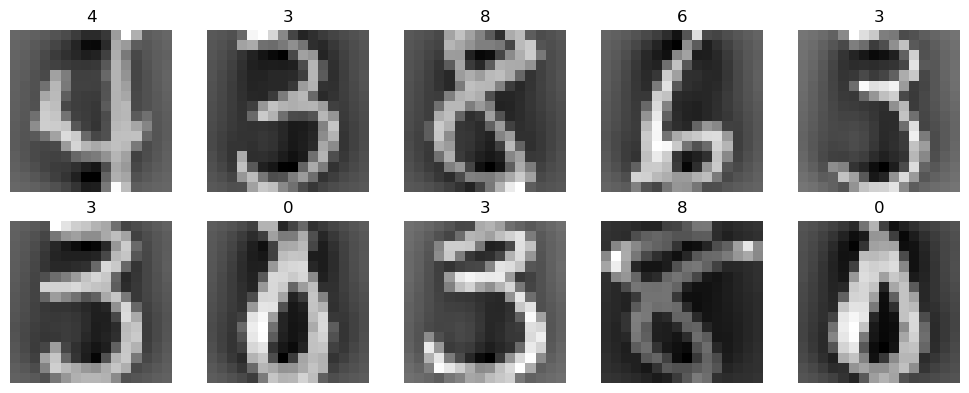

cluster 7


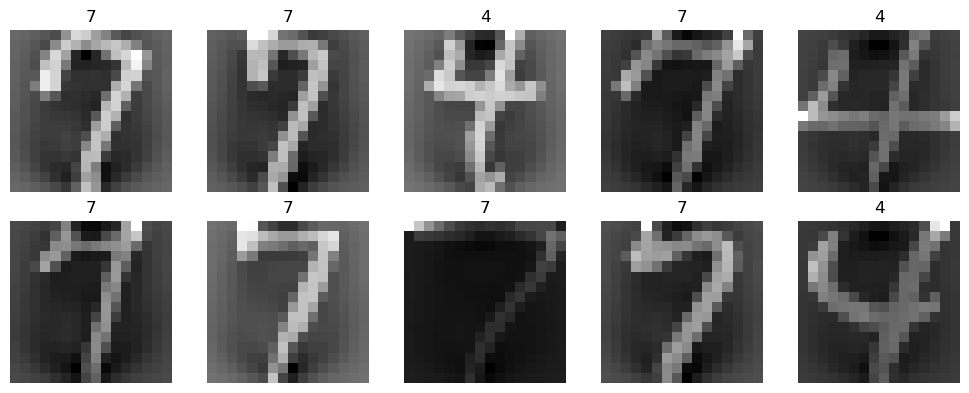

cluster 8


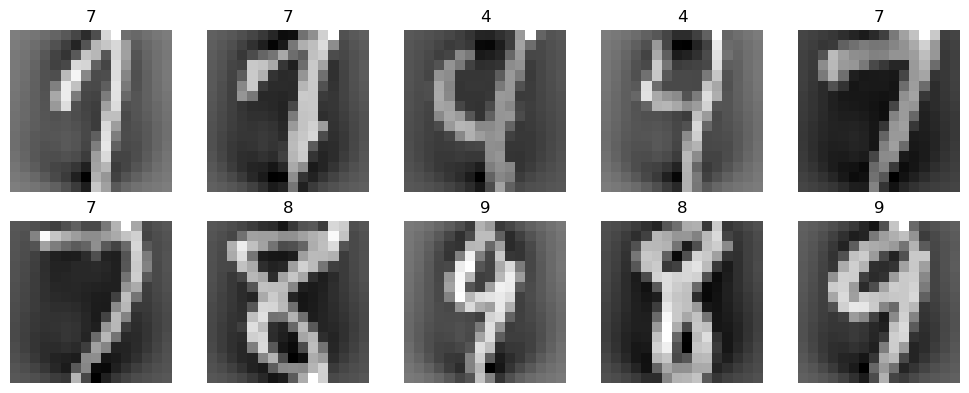

cluster 9


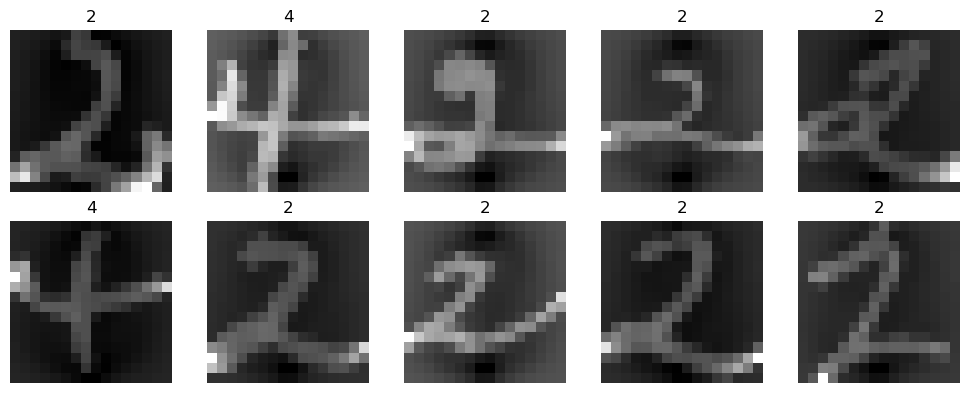

In [41]:
groupes = df_rep.groupby('Cluster')
groupes_df_rep = []
# Parcourir chaque groupe
for cluster, groupe_df in groupes:
    groupes_df_rep.append(groupe_df)
    
for i in range(10):
    print('cluster', i)
    afficher_images_cluster_rep(groupes_df_rep[i], trainx, train_y)

In [ ]:
df_eval = pd.DataFrame([
    ('score silhouette', silhouette_score(trainx, labels), silhouette_score(representations_latentes, labels_rep)),
     ('Inertie', kmeans.inertia_, kmeans_rep.inertia_)
], columns=['Metrique', 'Clustering espace original', 'Clustering espace latent'])
df_eval

,Metrique,Clustering espace original,Clustering espace latent
0,score silhouette,0.093621,0.397438
1,Inertie,172488.643835,2653.045795


In [47]:
for df in groupes_df_rep:
    df['Chiffre'] = [train_y[rep] for rep in df['RepresentationLatente']]

cluster_valMaj_purete = []
for df in groupes_df_rep:
    value_count = df['Chiffre'].value_counts()
    cluster_valMaj_purete.append((df.iloc[0]["Cluster"], value_count.idxmax(), value_count.max()/len(df)))

df_cluster_valMaj_purete = pd.DataFrame(cluster_valMaj_purete, columns=['Cluster', 'ValeurMajoritaire', 'purete'])

print('mean: ', np.mean(df_cluster_valMaj_purete['purete'].to_list()))
print('std: ',np.std(df_cluster_valMaj_purete['purete'].to_list()))

df_cluster_valMaj_purete

mean:  0.5098547606015204
std:  0.24684338281781676


,Cluster,ValeurMajoritaire,purete
0,0,5,0.250000
1,1,0,0.654762
2,2,1,0.705882
3,3,0,0.431579
4,4,2,0.953846
5,5,4,0.195122
6,6,3,0.391304
7,7,7,0.368000
8,8,9,0.311688
9,9,2,0.836364


Ici on a une plus grande variance mais on a certains clusters qui sont plus pures, comme celui composé d'images de '2'

### Autre config

In [58]:
#ensemble de train Complet et même architecture que le précédent
loss_bce = BCELoss()
lineaire1 = Linear(trainx.shape[1], 128, init_type=1)
lineaire2 = Linear(128, 64, init_type=1)
lineaire3 = Linear(64, 128, init_type=1)
lineaire4 = Linear(128, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=100

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_bce, nb_epochs=iter, eps=1e-2, shuffle=True)


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


In [60]:
representations_latentes = np.array([net.get_representation_latente(trainx[i].reshape((1,256))) for i in range(len(trainx))])
representations_latentes = np.squeeze(representations_latentes)
np.savetxt('representations_latentes.txt', representations_latentes)
representations_latentes

array([[-1.,  1., -1., ...,  1.,  1., -1.],
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1., -1.,  1.],
       ...,
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [-1.,  1., -1., ...,  1.,  1.,  1.],
       [-1., -1.,  1., ..., -1., -1., -1.]])

In [59]:
representations_latentes = np.loadtxt('representations_latentes/representations_latentes3.txt')

In [52]:
kmeans_rep = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(representations_latentes)
# Pour obtenir les étiquettes de cluster pour chaque image
labels_rep = kmeans_rep.predict(representations_latentes)
image_cluster_rep = []

# Associer chaque image à son cluster
for i in range(len(labels_rep)):
    image_cluster_rep.append((i,labels_rep[i]))

df_rep = pd.DataFrame(image_cluster_rep, columns=['RepresentationLatente', 'Cluster'])
df_rep

,RepresentationLatente,Cluster
0,0,8
1,1,4
2,2,2
3,3,1
4,4,6
...,...,...
7286,7286,6
7287,7287,1
7288,7288,6
7289,7289,4


cluster 0


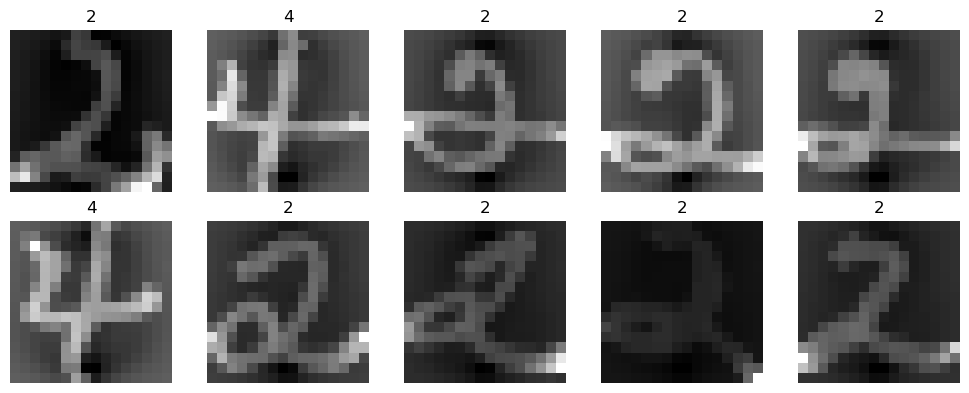

cluster 1


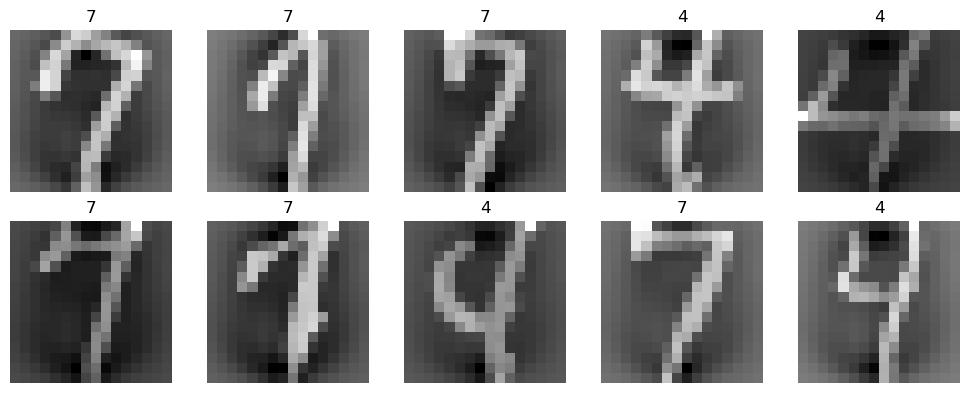

cluster 2


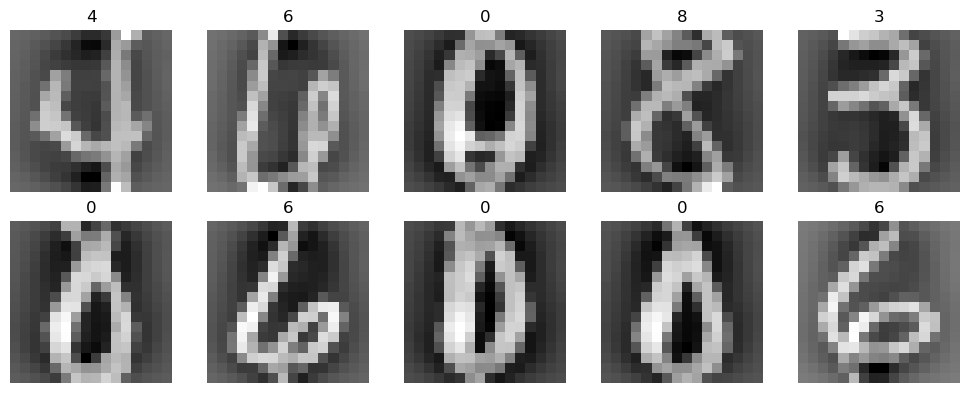

cluster 3


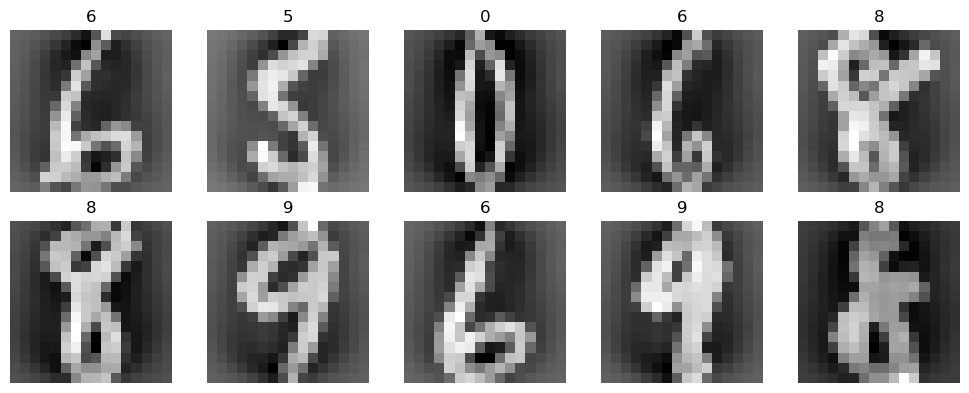

cluster 4


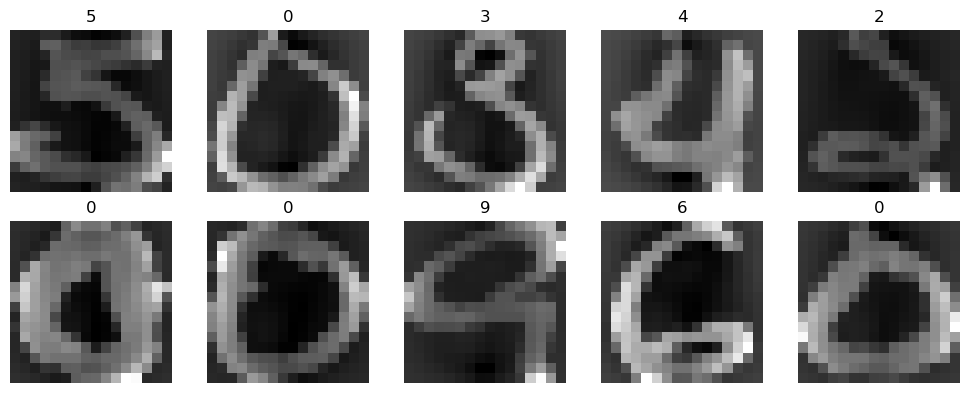

cluster 5


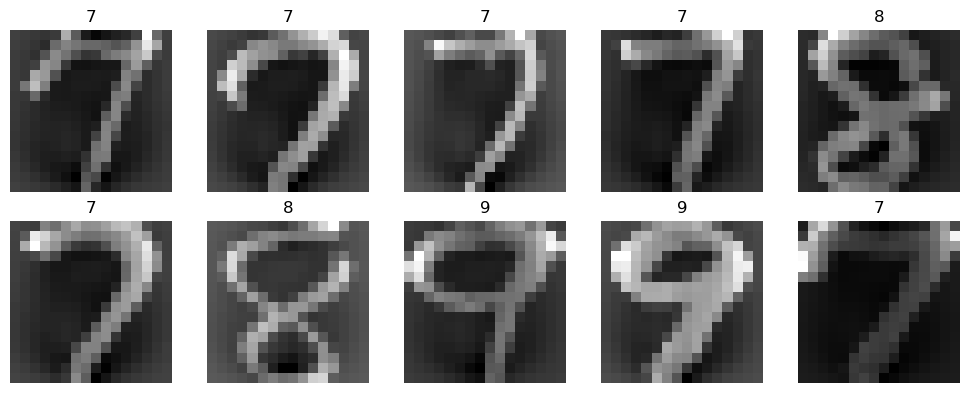

cluster 6


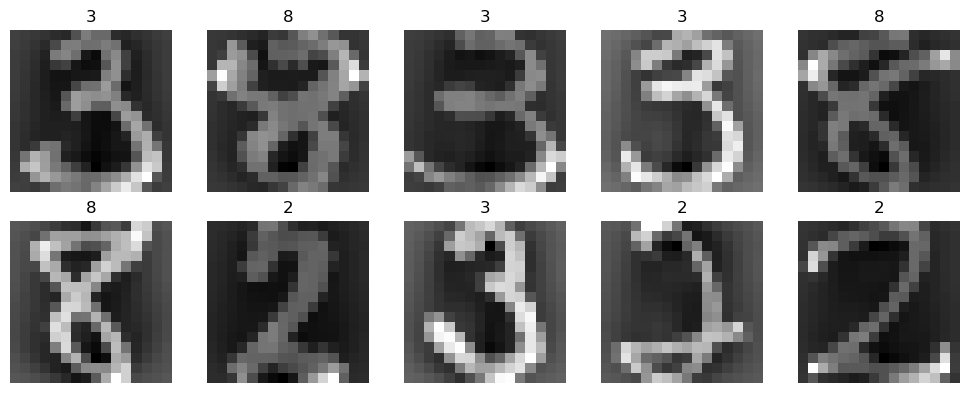

cluster 7


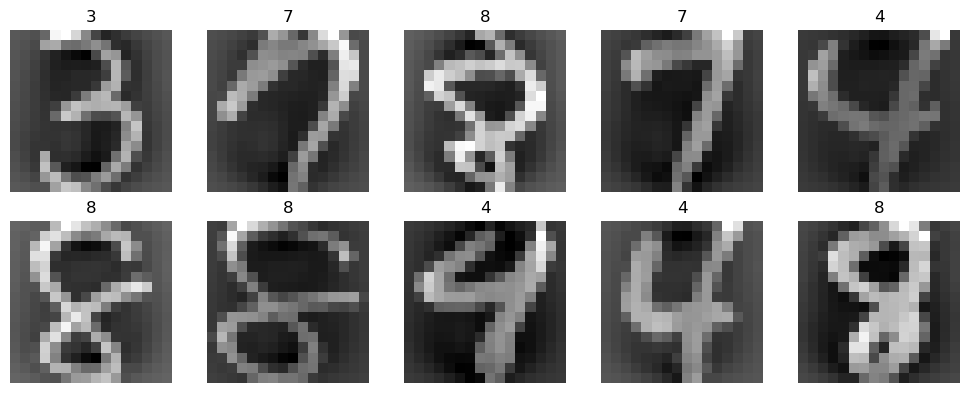

cluster 8


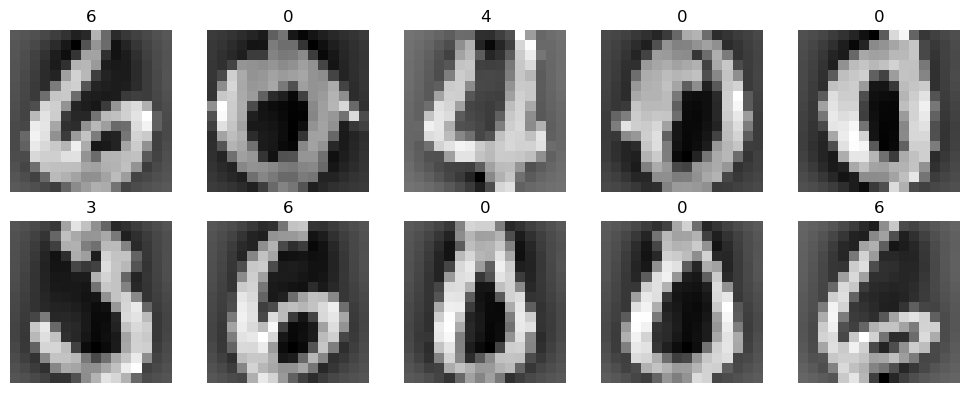

cluster 9


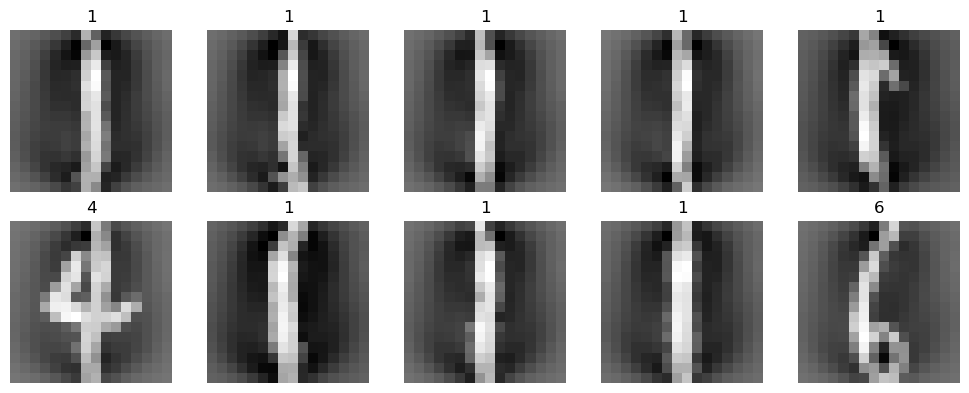

In [53]:
groupes = df_rep.groupby('Cluster')
groupes_df_rep = []
# Parcourir chaque groupe
for cluster, groupe_df in groupes:
    groupes_df_rep.append(groupe_df)
    
for i in range(10):
    print('cluster', i)
    afficher_images_cluster_rep(groupes_df_rep[i], trainx, train_y)

In [54]:
df_eval = pd.DataFrame([
    ('score silhouette', silhouette_score(trainx, labels), silhouette_score(representations_latentes, labels_rep)),
     ('Inertie', kmeans.inertia_, kmeans_rep.inertia_)
], columns=['Metrique', 'Clustering espace original', 'Clustering espace latent'])
df_eval

,Metrique,Clustering espace original,Clustering espace latent
0,score silhouette,1.069662e-01,0.184465
1,Inertie,1.227543e+06,182805.112488


In [55]:
for df in groupes_df_rep:
    df['Chiffre'] = [train_y[rep] for rep in df['RepresentationLatente']]

cluster_valMaj_purete = []
for df in groupes_df_rep:
    value_count = df['Chiffre'].value_counts()
    cluster_valMaj_purete.append((df.iloc[0]["Cluster"], value_count.idxmax(), value_count.max()/len(df)))

df_cluster_valMaj_purete = pd.DataFrame(cluster_valMaj_purete, columns=['Cluster', 'ValeurMajoritaire', 'purete'])

print('mean: ', np.mean(df_cluster_valMaj_purete['purete'].to_list()))
print('std: ',np.std(df_cluster_valMaj_purete['purete'].to_list()))

df_cluster_valMaj_purete

mean:  0.5392357082706849
std:  0.16817359775404506


,Cluster,ValeurMajoritaire,purete
0,0,2,0.783333
1,1,9,0.348998
2,2,6,0.375254
3,3,6,0.336957
4,4,0,0.547575
5,5,7,0.613699
6,6,3,0.629060
7,7,4,0.402626
8,8,0,0.521378
9,9,1,0.833479


## T-SNE

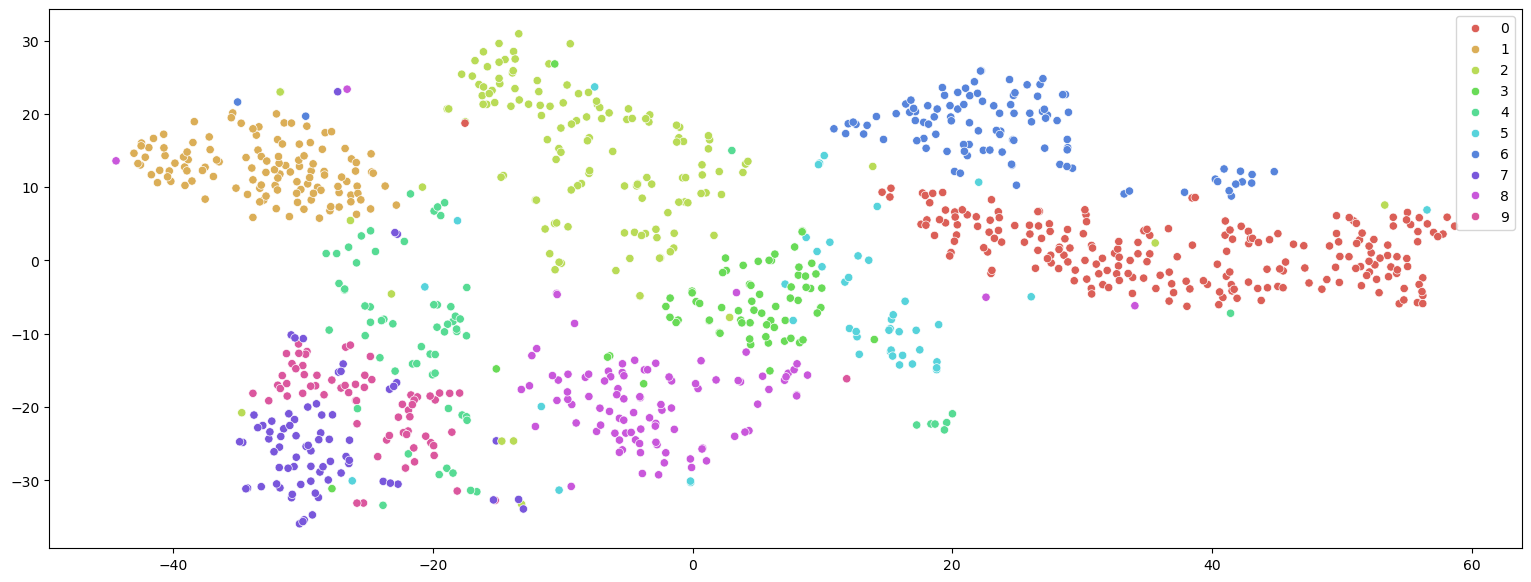

In [67]:
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(trainx)

plt.figure(figsize=(19,7))
sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = train_y, palette = sns.hls_palette(10), legend = 'full')
plt.show()

In [77]:
representations_latentes = np.loadtxt('representations_latentes/representations_latentes3.txt')

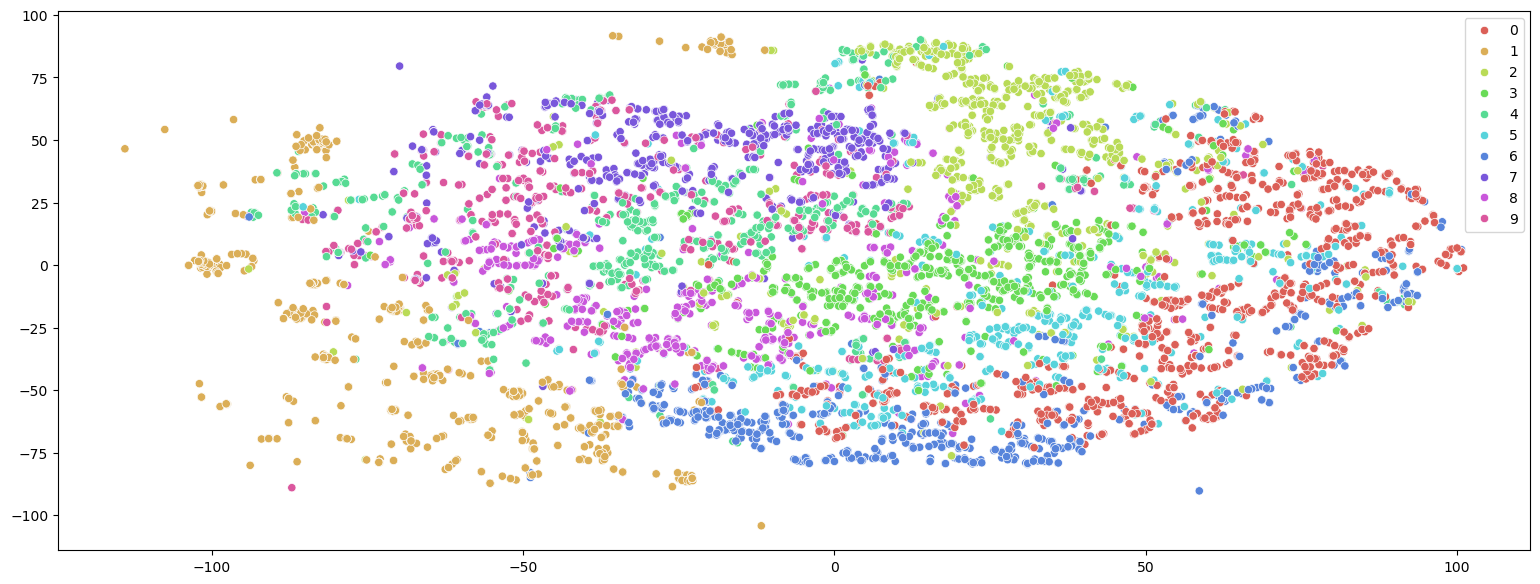

In [75]:
tsne_rep = TSNE(n_components = 2, random_state=0, perplexity=10)
tsne_rep_res = tsne_rep.fit_transform(representations_latentes)

plt.figure(figsize=(19,7))
sns.scatterplot(x = tsne_rep_res[:,0], y = tsne_rep_res[:,1], hue = train_y, palette = sns.hls_palette(10), legend = 'full')
plt.show()

# Classification

In [5]:
representations_latentes = np.loadtxt('representations_latentes/representations_latentes.txt')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(representations_latentes, train_y[:len(representations_latentes)], test_size=0.2, random_state=42)
y_train_one_hot = transform_one_hot(y_train)
y_test_one_hot = transform_one_hot(y_test)
loss_celogsoftmax = CELogSoftMax()
softmax = SoftMax()


100%|██████████| 1000/1000 [00:14<00:00, 69.78it/s]


accuracy train:  0.58875
accuracy test:  0.565


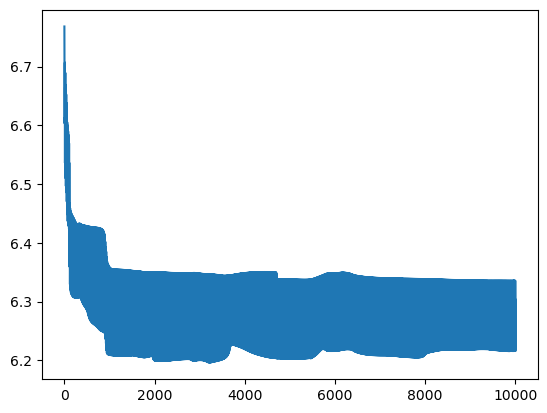

In [13]:
net2 = Sequentiel(Linear(10, 32, 'lin1'), Tanh(), Linear(32, 10, 'lin2'), softmax)
net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=1000, eps=1e-2, shuffle=False)
raw_scores_train = net2.forward(X_train)
raw_scores_test = net2.forward(X_test)

print("accuracy train: ", score(y_train, raw_scores_train))
print("accuracy test: ", score(y_test, raw_scores_test))
plt.plot(np.arange(len(couts2)), couts2)

100%|██████████| 2000/2000 [01:00<00:00, 32.96it/s]


accuracy train:  0.67625
accuracy test:  0.665


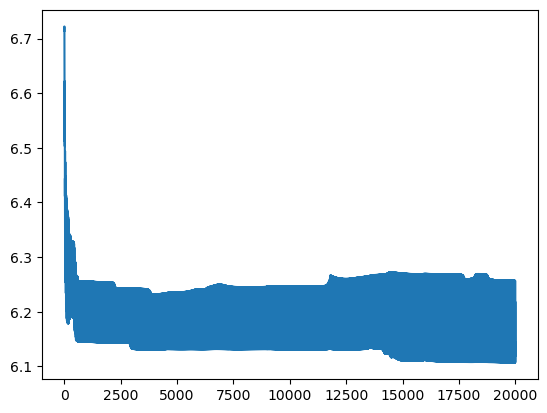

In [14]:
net2 = Sequentiel(Linear(10, 80, 'lin1'), Tanh(), Linear(80, 10, 'lin2'), softmax)
net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=2000, eps=1e-2, shuffle=True)
raw_scores_train = net2.forward(X_train)
raw_scores_test = net2.forward(X_test)

print("accuracy train: ", score(y_train, raw_scores_train))
print("accuracy test: ", score(y_test, raw_scores_test))
plt.plot(np.arange(len(couts2)), couts2)

100%|██████████| 1000/1000 [00:26<00:00, 37.44it/s]


accuracy train:  0.63375
accuracy test:  0.59


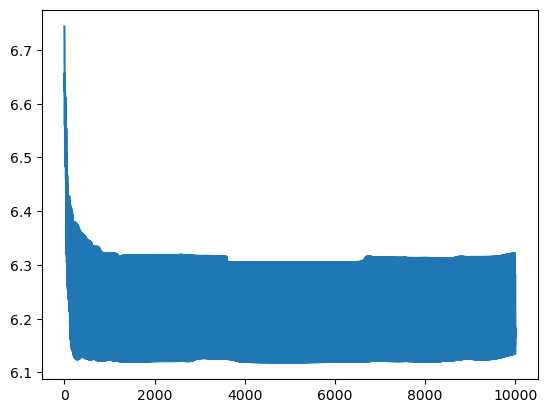

In [16]:
net2 = Sequentiel(Linear(10, 100, 'lin1'), Tanh(), Linear(100, 10, 'lin2'), softmax)
net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=1000, eps=1e-2, shuffle=True)
raw_scores_train = net2.forward(X_train)
raw_scores_test = net2.forward(X_test)

print("accuracy train: ", score(y_train, raw_scores_train))
print("accuracy test: ", score(y_test, raw_scores_test))
plt.plot(np.arange(len(couts2)), couts2)

## Classification avec autre dimension latente

In [5]:
loss_bce = BCELoss()
lineaire1 = Linear(trainx.shape[1], 128, init_type=1)
lineaire2 = Linear(128, 64, init_type=1)
lineaire3 = Linear(64, 128, init_type=1)
lineaire4 = Linear(128, trainx.shape[1], init_type=1)
sig = Sigmoide()
tanh = Tanh()
tanh2 = Tanh()
tanh3 = Tanh()

iter=200

net = AutoEncodeur(lineaire1, tanh, lineaire2, tanh2, lineaire3, tanh3, lineaire4, sig)

net, couts, opt = SGD(net, trainx, trainx,nb_batch=10, loss=loss_bce, nb_epochs=iter, eps=1e-2, shuffle=True)


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


In [6]:
representations_latentes = np.array([net.get_representation_latente(trainx[i].reshape((1,256))) for i in range(len(trainx))])
representations_latentes = np.squeeze(representations_latentes)
np.savetxt('representations_latentes4.txt', representations_latentes)
representations_latentes

array([[-1.,  1., -1., ...,  1.,  1., -1.],
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1., -1., -1.],
       ...,
       [ 1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1., -1.],
       [-1., -1.,  1., ..., -1., -1.,  1.]])

In [5]:
representations_latentes = np.loadtxt('representations_latentes/representations_latentes4.txt')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(representations_latentes, train_y[:len(representations_latentes)], test_size=0.2, random_state=42)
y_train_one_hot = transform_one_hot(y_train)
y_test_one_hot = transform_one_hot(y_test)
loss_celogsoftmax = CELogSoftMax()
softmax = SoftMax()


100%|██████████| 500/500 [00:21<00:00, 22.76it/s]


accuracy train:  0.647119341563786
accuracy test:  0.6339958875942426


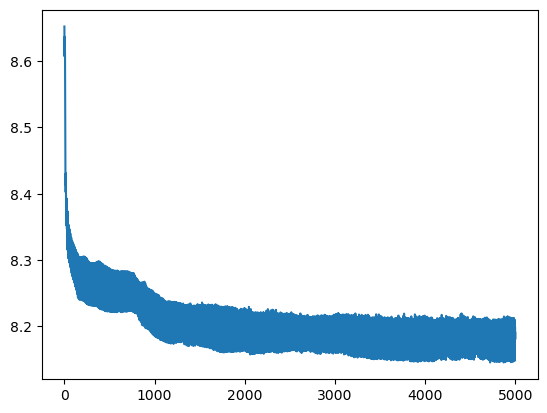

In [11]:
net2 = Sequentiel(Linear(64, 32, 'lin1'), Tanh(), Linear(32, 10, 'lin2'), softmax)
net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=10, loss=loss_celogsoftmax, nb_epochs=500, eps=1e-2, shuffle=True)
raw_scores_train = net2.forward(X_train)
raw_scores_test = net2.forward(X_test)

print("accuracy train: ", score(y_train, raw_scores_train))
print("accuracy test: ", score(y_test, raw_scores_test))
plt.plot(np.arange(len(couts2)), couts2)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 35.79it/s]


accuracy train:  0.4890260631001372
accuracy test:  0.5147361206305688


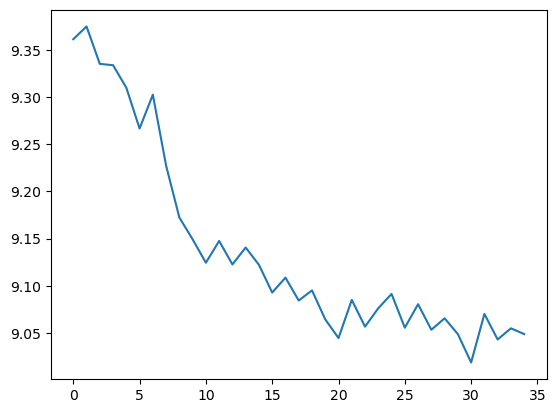

In [41]:
net2 = Sequentiel(Linear(64, 32, 'lin1'), ReLU(), Linear(32, 10, 'lin2'), softmax)

net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=5, loss=loss_celogsoftmax, nb_epochs=7, eps=1e-2, shuffle=True)

raw_scores_train = net2.forward(X_train)
raw_scores_test = net2.forward(X_test)


print("accuracy train: ", score(y_train, raw_scores_train))
print("accuracy test: ", score(y_test, raw_scores_test))
plt.plot(np.arange(len(couts2)), couts2)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 30.29it/s]


accuracy train:  0.5944787379972565
accuracy test:  0.6058944482522276


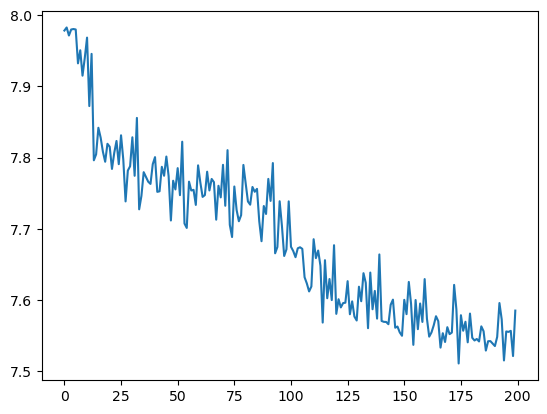

In [9]:
net2 = Sequentiel(Linear(64, 80, 'lin1'), ReLU(), Linear(80, 10, 'lin2'), softmax)

net2, couts2, opt2 = SGD(net2, X_train, y_train_one_hot, nb_batch=20, loss=loss_celogsoftmax, nb_epochs=10, eps=1e-2, shuffle=True)

raw_scores_train = net2.forward(X_train)
raw_scores_test = net2.forward(X_test)


print("accuracy train: ", score(y_train, raw_scores_train))
print("accuracy test: ", score(y_test, raw_scores_test))
plt.plot(np.arange(len(couts2)), couts2)

